# *(Brette, et, al., 2007)* COBA

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95



Authors:

- [Chaoming Wang](https://github.com/chaoming0625)


In [1]:
import brainpy as bp

bp.math.set_platform('cpu')

## Version 1

In [2]:
class EINet(bp.Network):
  def __init__(self, scale=1.0, method='exp_auto'):
    # network size
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                V_initializer=bp.init.Normal(-55., 2.))
    E = bp.neurons.LIF(num_exc, **pars, method=method)
    I = bp.neurons.LIF(num_inh, **pars, method=method)

    # synapses
    we = 0.6 / scale  # excitatory synaptic weight (voltage)
    wi = 6.7 / scale  # inhibitory synaptic weight
    E2E = bp.synapses.Exponential(E, E, bp.conn.FixedProb(prob=0.02),
                                  g_max=we, tau=5., method=method,
                                  output=bp.synouts.COBA(E=0.))
    E2I = bp.synapses.Exponential(E, I, bp.conn.FixedProb(prob=0.02),
                                  g_max=we, tau=5., method=method,
                                  output=bp.synouts.COBA(E=0.))
    I2E = bp.synapses.Exponential(I, E, bp.conn.FixedProb(prob=0.02),
                                  g_max=wi, tau=10., method=method,
                                  output=bp.synouts.COBA(E=-80.))
    I2I = bp.synapses.Exponential(I, I, bp.conn.FixedProb(prob=0.02),
                                  g_max=wi, tau=10., method=method,
                                  output=bp.synouts.COBA(E=-80.))

    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

In [3]:
# network
net = EINet()

In [4]:
# simulation
runner = bp.DSRunner(
  net,
  monitors=['E.spike'],
  inputs=[('E.input', 20.), ('I.input', 20.)]
)
runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

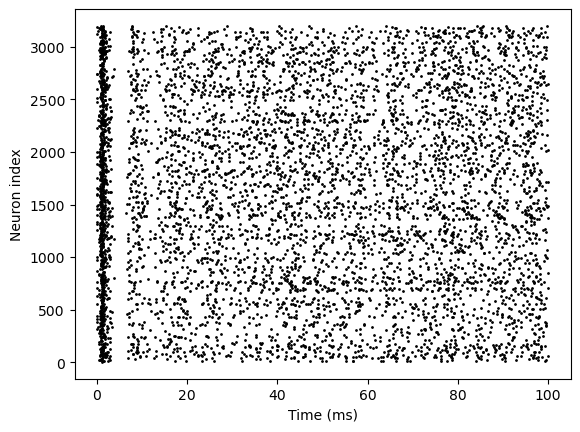

In [5]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)

## Version 2

In [6]:
class EINet_V2(bp.Network):
  def __init__(self, scale=1.0, method='exp_auto'):
    super(EINet_V2, self).__init__()

    # network size
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)

    # neurons
    self.N = bp.neurons.LIF(num_exc + num_inh,
                            V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                            method=method, V_initializer=bp.initialize.Normal(-55., 2.))

    # synapses
    we = 0.6 / scale  # excitatory synaptic weight (voltage)
    wi = 6.7 / scale  # inhibitory synaptic weight
    self.Esyn = bp.synapses.Exponential(pre=self.N[:num_exc],
                                        post=self.N,
                                        conn=bp.connect.FixedProb(0.02),
                                        g_max=we, tau=5.,
                                        output=bp.synouts.COBA(E=0.),
                                        method=method)
    self.Isyn = bp.synapses.Exponential(pre=self.N[num_exc:],
                                        post=self.N,
                                        conn=bp.connect.FixedProb(0.02),
                                        g_max=wi, tau=10.,
                                        output=bp.synouts.COBA(E=-80.),
                                        method=method)

  0%|          | 0/1000 [00:00<?, ?it/s]

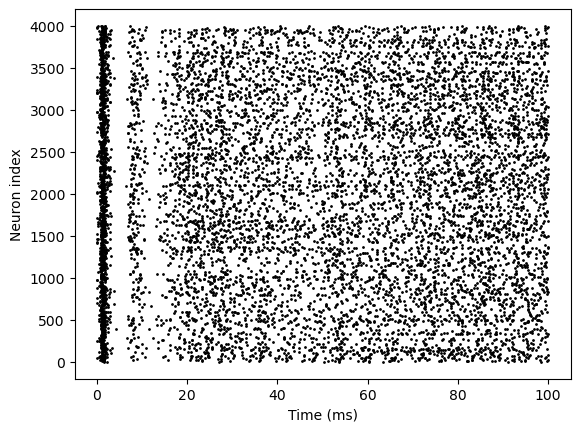

In [7]:
net = EINet_V2(scale=1., method='exp_auto')
# simulation
runner = bp.DSRunner(
net,
monitors={'spikes': net.N.spike},
inputs=[(net.N.input, 20.)]
)
runner.run(100.)

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['spikes'], show=True)